# Sampling Methods #
## Joon Yuhl Soh ##

For the CHD data develop two models with fewer
predictor variables and/or with a nonlinear transformation of one of the
the predictor variables.


In [ ]:
import numpy as np
import scipy.stats as st
import scipy.linalg as la
import matplotlib.pyplot as pp
import pandas as pd
import pymc3 as pm
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import arviz as az
import seaborn as sns
import theano.tensor as tt
%matplotlib inline
pp.style.use('seaborn-darkgrid')

In [113]:
data_c = pd.read_csv("CHDdata.csv")
data_c.head(5)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


Fist, make sure categorical values are recorded properly

In [114]:
replace_map = {
    'famhist':{
        'Absent':-1,
        'Present':1
    },
    'chd':{
        1:0.9999,
        0:0.0001
    }
}
data_c = data_c.replace(replace_map)
data_c.head(5)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,0.9999
1,144,0.01,4.41,28.61,-1,55,28.87,2.06,63,0.9999
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0.0001
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,0.9999
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,0.9999


Then make sure other colums are also standardized. 

In [115]:
numCols = ['sbp', 'tobacco', 'ldl', 'adiposity','typea','obesity','alcohol','age']
for i in numCols :
    data_c[i] = (data_c[i] - data_c[i].mean()) / data_c[i].std()
data_c.head(5)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.057417,1.821099,0.477894,-0.295183,1,-0.418017,-0.176594,3.274189,0.628654,0.9999
1,0.276789,-0.789382,-0.159507,0.411694,-1,0.193134,0.670646,-0.612081,1.381617,0.9999
2,-0.991731,-0.774141,-0.608585,0.883374,1,-0.112441,0.734723,-0.540597,0.217947,0.0001
3,1.545310,0.841352,0.806252,1.622382,1,-0.214300,1.411091,0.294742,1.039361,0.9999
4,-0.211103,2.169453,-0.598928,0.305020,1,0.702427,-0.012842,1.645991,0.423301,0.9999


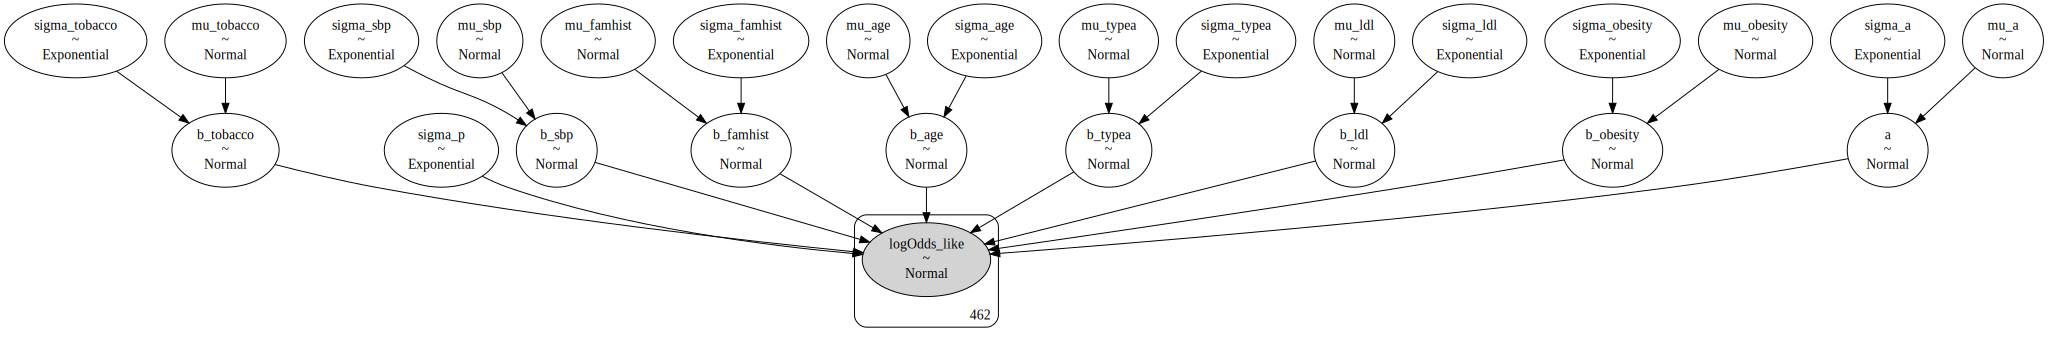

In [121]:
with Model() as varying_logOdds2:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=9999)
    sigma_a = pm.Exponential("sigma_a", 1)
    
    mu_sbp = pm.Normal('mu_sbp', mu=0, sd=9999)
    sigma_sbp = pm.Exponential("sigma_sbp", 1)
    
    mu_tobacco = pm.Normal('mu_tobacco', mu=0, sd=9999)
    sigma_tobacco = pm.Exponential("sigma_tobacco", 1)
    
    mu_ldl = pm.Normal('mu_ldl', mu=0, sd=9999)
    sigma_ldl = pm.Exponential("sigma_ldl", 1)
    
    mu_famhist = pm.Normal('mu_famhist', mu=0, sd=9999)
    sigma_famhist = pm.Exponential("sigma_famhist", 1)
    
    mu_typea = pm.Normal('mu_typea', mu=0, sd=9999)
    sigma_typea = pm.Exponential("sigma_typea", 1)
    
    mu_obesity = pm.Normal('mu_obesity', mu=0, sd=9999)
    sigma_obesity = pm.Exponential("sigma_obesity", 1)
    
    mu_age = pm.Normal('mu_age', mu=0, sd=9999)
    sigma_age = pm.Exponential("sigma_age", 1)
    
    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a)
    # Random slopes
    b_sbp = pm.Normal('b_sbp', mu=mu_sbp, sd=sigma_sbp)
    b_tobacco = pm.Normal('b_tobacco', mu=mu_tobacco, sd=sigma_tobacco)
    b_ldl = pm.Normal('b_ldl', mu=mu_ldl, sd=sigma_ldl)
    b_famhist = pm.Normal('b_famhist', mu=mu_famhist, sd=sigma_famhist)
    b_typea = pm.Normal('b_typea', mu=mu_typea, sd=sigma_typea)
    b_obesity = pm.Normal('b_obesity', mu=mu_obesity, sd=sigma_obesity)
    b_age = pm.Normal('b_age', mu=mu_age, sd=sigma_age)
    
    # Expected value
    logOdds_hat = a + b_sbp * data_c.sbp.values + b_tobacco * data_c.tobacco.values + b_ldl * data_c.ldl.values + b_famhist * data_c.famhist.values + b_typea * data_c.typea.values + b_obesity * data_c.obesity.values + b_age * data_c.age.values
    
    sigma_p = pm.Exponential("sigma_p", 1)
    logOdds_true = tt.log(data_c.chd.values / (1 - data_c.chd.values))
    
    # Data likelihood
    logOdds_like = pm.Normal('logOdds_like', mu=logOdds_hat, sd=sigma_p, observed=logOdds_true)
pm.model_to_graphviz(varying_logOdds2)

In [122]:
with varying_logOdds2:
    varying_logOdds2_trace = pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 6, tune=5000)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_p, b_age, b_obesity, b_typea, b_famhist, b_ldl, b_tobacco, b_sbp, a, sigma_age, mu_age, sigma_obesity, mu_obesity, sigma_typea, mu_typea, sigma_famhist, mu_famhist, sigma_ldl, mu_ldl, sigma_tobacco, mu_tobacco, sigma_sbp, mu_sbp, sigma_a, mu_a]


Sampling 6 chains for 5_000 tune and 500 draw iterations (30_000 + 3_000 draws total) took 871 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9096268220491447, but should be close to 0.99. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


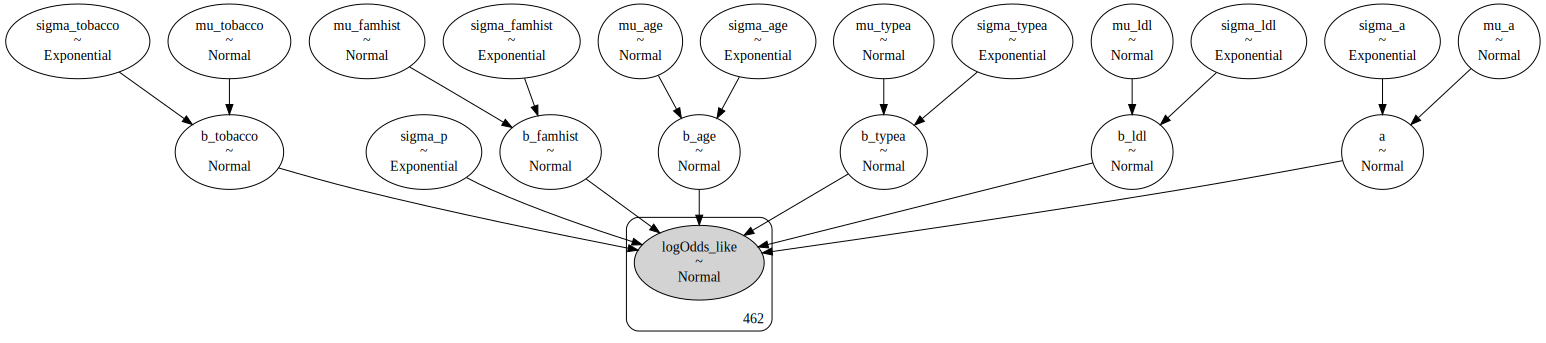

In [123]:
with Model() as varying_logOdds3:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=9999)
    sigma_a = pm.Exponential("sigma_a", 1)
    
    mu_tobacco = pm.Normal('mu_tobacco', mu=0, sd=9999)
    sigma_tobacco = pm.Exponential("sigma_tobacco", 1)
    
    mu_ldl = pm.Normal('mu_ldl', mu=0, sd=9999)
    sigma_ldl = pm.Exponential("sigma_ldl", 1)
    
    mu_famhist = pm.Normal('mu_famhist', mu=0, sd=9999)
    sigma_famhist = pm.Exponential("sigma_famhist", 1)
    
    mu_typea = pm.Normal('mu_typea', mu=0, sd=9999)
    sigma_typea = pm.Exponential("sigma_typea", 1)
    
    mu_age = pm.Normal('mu_age', mu=0, sd=9999)
    sigma_age = pm.Exponential("sigma_age", 1)
    
    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a)
    # Random slopes
    b_tobacco = pm.Normal('b_tobacco', mu=mu_tobacco, sd=sigma_tobacco)
    b_ldl = pm.Normal('b_ldl', mu=mu_ldl, sd=sigma_ldl)
    b_famhist = pm.Normal('b_famhist', mu=mu_famhist, sd=sigma_famhist)
    b_typea = pm.Normal('b_typea', mu=mu_typea, sd=sigma_typea)
    b_age = pm.Normal('b_age', mu=mu_age, sd=sigma_age)
    
    # Expected value
    logOdds_hat = a + b_tobacco * data_c.tobacco.values + b_ldl * data_c.ldl.values + b_famhist * data_c.famhist.values + b_typea * data_c.typea.values + b_age * data_c.age.values
    
    sigma_p = pm.Exponential("sigma_p", 1)
    logOdds_true = tt.log(data_c.chd.values / (1 - data_c.chd.values))
    
    # Data likelihood
    logOdds_like = pm.Normal('logOdds_like', mu=logOdds_hat, sd=sigma_p, observed=logOdds_true)
pm.model_to_graphviz(varying_logOdds3)

In [124]:
with varying_logOdds3:
    varying_logOdds3_trace = pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 6, tune=5000)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_p, b_age, b_typea, b_famhist, b_ldl, b_tobacco, a, sigma_age, mu_age, sigma_typea, mu_typea, sigma_famhist, mu_famhist, sigma_ldl, mu_ldl, sigma_tobacco, mu_tobacco, sigma_a, mu_a]


Sampling 6 chains for 5_000 tune and 500 draw iterations (30_000 + 3_000 draws total) took 499 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [125]:
with varying_logOdds:
    waic1 = az.waic(varying_logOdds_trace)
waic1

Computed from 3000 by 462 log-likelihood matrix

          Estimate       SE
elpd_waic -1607.48    11.25
p_waic       11.02        -

In [126]:
with varying_logOdds2:
    waic2 = az.waic(varying_logOdds2_trace)
waic2

Computed from 3000 by 462 log-likelihood matrix

          Estimate       SE
elpd_waic -1605.29    11.24
p_waic        8.67        -

In [127]:
with varying_logOdds3:
    waic3 = az.waic(varying_logOdds3_trace)
waic3

Computed from 3000 by 462 log-likelihood matrix

          Estimate       SE
elpd_waic -1605.12    11.00
p_waic        6.30        -

• Use WAIC to recommend which of these models to use

Based on the minimum WAIC score, the first model (varying_logOdds) with all predictors is actually recommended. However, since the difference is small, I would like to use the one with minimum number of predictors.

• Use WAIC to produce a Bayesian model average result. Show the
kernel density plots for the sample posterior predictions of each of
the models and the Bayesian model average.

In [129]:
import math
waic_star = -1607.48
dk1 = -1607.48 - waic_star
w1_0 = math.exp(-1/2*dk1)
dk2 = -1605.29 - waic_star
w2_0 = math.exp(-1/2*dk2)
dk3 = -1605.12 - waic_star
w3_0 = math.exp(-1/2*dk3)
den = w1_0 + w2_0 + w3_0

w1 = w1_0/den
w2 = w2_0/den
w3 = w3_0/den

• Use WAIC to produce a Bayesian model average result. Show the
kernel density plots for the sample posterior predictions of each of
the models and the Bayesian model average.


In [213]:
y_1 = pm.sample_posterior_predictive_w(traces = [varying_logOdds_trace],
                                        samples=500,
                                        models=[ varying_logOdds])
y_2 = pm.sample_posterior_predictive_w(traces = [varying_logOdds2_trace],
                                        samples=500,
                                        models=[ varying_logOdds2])
y_3 = pm.sample_posterior_predictive_w(traces = [varying_logOdds3_trace],
                                        samples=500,
                                        models=[ varying_logOdds3])

In [214]:
weights = [w1, w2, w3]
y_bma = pm.sample_posterior_predictive_w(traces = [varying_logOdds_trace, varying_logOdds2_trace, varying_logOdds3_trace],
                                        samples=500,
                                        models=[varying_logOdds, varying_logOdds2, varying_logOdds3],
                                        weights=weights)

In [221]:
y_1.keys()

dict_keys(['logOdds_like'])

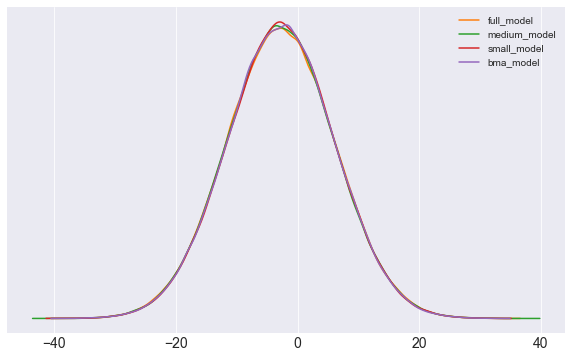

In [223]:
_, ax = pp.subplots(figsize=(10, 6))
az.plot_kde(y_1['logOdds_like'], plot_kwargs={'color': 'C1'}, label='full_model', ax=ax)
az.plot_kde(y_2['logOdds_like'], plot_kwargs={'color': 'C2'}, label='medium_model', ax=ax)
az.plot_kde(y_3['logOdds_like'], plot_kwargs={'color': 'C3'}, label='small_model', ax=ax)
az.plot_kde(y_bma['logOdds_like'], plot_kwargs={'color': 'C4'}, label='bma_model', ax=ax)

pp.yticks([])
pp.legend()

As expected, the models without the averaging or some of the predictors that are considered not useful performed similarly. Thus, I would like to use the one with minimum number of predictors 

Show the overlaid plots of the predictions for
the data points in the CHDdata.csv file with age on the x-axis and
the predicted probability on the y-axis. Overlay these results for each
model and for the Bayesian model average of the models.

In [207]:
s1 = pd.DataFrame([[varying_logOdds_trace['b_sbp'].mean()], 
                     [varying_logOdds_trace['b_tobacco'].mean()], 
                     [varying_logOdds_trace['b_ldl'].mean()], 
                     [varying_logOdds_trace['b_adiposity'].mean()], 
                     [varying_logOdds_trace['b_obesity'].mean()], 
                     [varying_logOdds_trace['b_alcohol'].mean()],  
                     [varying_logOdds_trace['b_famhist'].mean()], 
                     [varying_logOdds_trace['b_typea'].mean()], 
                     [varying_logOdds_trace['b_age'].mean()]])

s2 = pd.DataFrame([[varying_logOdds_trace['b_sbp'].mean()], 
                     [varying_logOdds_trace['b_tobacco'].mean()], 
                     [varying_logOdds_trace['b_ldl'].mean()], 
                     [varying_logOdds_trace['b_obesity'].mean()], 
                     [varying_logOdds_trace['b_famhist'].mean()], 
                     [varying_logOdds_trace['b_typea'].mean()], 
                     [varying_logOdds_trace['b_age'].mean()]])

s3 = pd.DataFrame([[varying_logOdds_trace['b_tobacco'].mean()], 
                     [varying_logOdds_trace['b_ldl'].mean()],
                     [varying_logOdds_trace['b_famhist'].mean()], 
                     [varying_logOdds_trace['b_typea'].mean()], 
                     [varying_logOdds_trace['b_age'].mean()]])

In [230]:
fakeDat1 = []
fakeDat2 = []
fakeDat3 = []
ageFake = []
for i in ['sbp', 'tobacco', 'ldl', 'adiposity', 'obesity','alcohol', 'famhist', 'typea', 'age'] :
    x_new = np.linspace(data_c[i].min(),data_c[i].max(), 100)
    fakeDat1.append(x_new)
    if i not in ['alcohol', 'adiposity'] :
        fakeDat2.append(x_new)
    if i not in ['alcohol', 'adiposity', 'obesity', 'sbp']:
        fakeDat3.append(x_new)
    if i is 'age' :
        ageFake.append(x_new)
    
fakeDF1 = pd.DataFrame(fakeDat1).T
fakeDF2 = pd.DataFrame(fakeDat2).T
fakeDF3 = pd.DataFrame(fakeDat3).T

In [231]:
y1 = fakeDF1.dot(s1)
y2 = fakeDF2.dot(s2)
y3 = fakeDF3.dot(s3)

In [267]:
pd.DataFrame(ageFake).T.shape

(100, 1)

In [268]:
y1.shape

(100, 1)

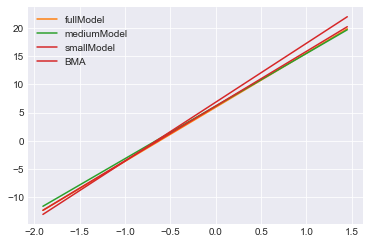

In [271]:
#Plot of both models
pp.plot(pd.DataFrame(ageFake).T, y1, 'C1', label='fullModel')
pp.plot(pd.DataFrame(ageFake).T, y2, 'C2', label='mediumModel')
pp.plot(pd.DataFrame(ageFake).T, y3, 'C3', label='smallModel')

y_bma = w1*y1 + w2*y2 + w3*y3

pp.plot(pd.DataFrame(ageFake).T, y_bma, c = 'C3', label='BMA')
pp.legend()
pp.show()

